In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn

import shap


from captum.attr import IntegratedGradients

In [173]:
train[:,0].shape

(60000,)

In [209]:
train = np.genfromtxt("mnist_train.csv", delimiter = ",", skip_header = 1, dtype=int)/255

# train_y = onehot(train[:,0]*255)
train_y = train[:,0]*255

In [229]:
train_y = torch.tensor(train_y, dtype= torch.long)

c:\Users\jakob\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [230]:
train_dat = torch.Tensor(train)

TypeError: new(): data must be a sequence (got function)

In [231]:
batch_size = 32

In [351]:
def onehot(l):
    one = torch.zeros((l.shape[0],10))

    for i, o in enumerate(l):
        one[i,int(o)] = 1

    return one


def loader(data, data_y, batch_size):
    for i in range(len(data)//batch_size):
        x, y = data[i*batch_size:(i+1)*batch_size,1:], data_y[i*batch_size:(i+1)*batch_size]
        yield x, y


train_loader = loader(train_dat, train_y, batch_size)


In [424]:
class nemt(nn.Module):
    def __init__(self):
        super(nemt, self).__init__()
        self.conv = nn.Conv2d(1, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(1440, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(self.conv(x.view(-1,28,28).unsqueeze(1)))
        x = F.relu(self.fc1(x.reshape(-1,1440)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = nemt()


In [425]:
loss_fn = nn.CrossEntropyLoss()

def train(model, n_epochs):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

    for i in range(n_epochs):
        train_loader = loader(train_dat, train_y, batch_size)

        running_loss = 0.0
        running_acc = 0.0
        c = 0
        for X, y in tqdm(train_loader, total = len(train_y)//batch_size):
            pred = model(X)
            loss = loss_fn(pred, y)

            acc = (pred.argmax(1) == y).detach().float().mean()

            running_loss += loss.detach().numpy()
            running_acc += acc

            loss.backward()
            optimizer.step()
            c += 1
        print(running_loss/c, running_acc/c)

train(model, 50)

  0%|          | 0/1875 [00:00<?, ?it/s]

1.0650035755922398 tensor(0.7293)


  0%|          | 0/1875 [00:00<?, ?it/s]

0.5304560046315193 tensor(0.8722)


  0%|          | 0/1875 [00:00<?, ?it/s]

0.3670498368129134 tensor(0.9007)


  0%|          | 0/1875 [00:00<?, ?it/s]

0.25145189612333974 tensor(0.9259)


  0%|          | 0/1875 [00:00<?, ?it/s]

0.1938475506797433 tensor(0.9435)


  0%|          | 0/1875 [00:00<?, ?it/s]

0.15271479028593749 tensor(0.9543)


  0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [296]:
i = 4

X, y = train_dat[i,1:].unsqueeze(0), train_y[i].unsqueeze(0)
pred_label = model(X)

print(y, pred_label.argmax())

tensor([9]) tensor(9)


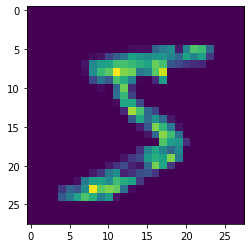

In [292]:
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients
import torchvision

# model = torchvision.models.resnet18(pretrained=True)
# model = model.eval()


i = 0

X, y = train_dat[i,1:].unsqueeze(0), train_y[i].unsqueeze(0)
pred_label = model(X)

# print(pred_label.shape, X.shape)
# print(torch.argmax(pred_label), y)
integrated_gradients = IntegratedGradients(model)

attributions_ig = integrated_gradients.attribute(X, target=torch.argmax(pred_label))

v = attributions_ig.squeeze(0).view(28,28).cpu().detach().numpy()
# plt.imshow(v)
plt.imshow(v + X.view(28,28).cpu().detach().numpy())
# viz.visualize_image_attr(v,
#                             torch.argmax(y),
#                             method='heat_map',)
#                             # show_colorbar=True,)
# #                             # sign='positive',)
# #                             # outlier_perc=1)

In [426]:
# params = next(model.parameters()).detach().view(-1,28,28)

# for p in params:
#     plt.imshow(p)
#     plt.show()
N = 5000
test_images = train_dat[N:N+6,1:]
bgr = train_dat[:N,1:]

e = shap.DeepExplainer(model, bgr)
shap_values = e.shap_values(test_images)


In [427]:
model(test_images).argmax(1)

tensor([7, 3, 9, 6, 1, 8])

In [428]:
train_loader = loader(train_dat, train_y, batch_size)

for X, y in train_loader:

    print(model(X).argmax(1),"\n", y)

    print((model(X).argmax(1) == y).detach().float().mean())
    break

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8]) 
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8])
tensor(1.)


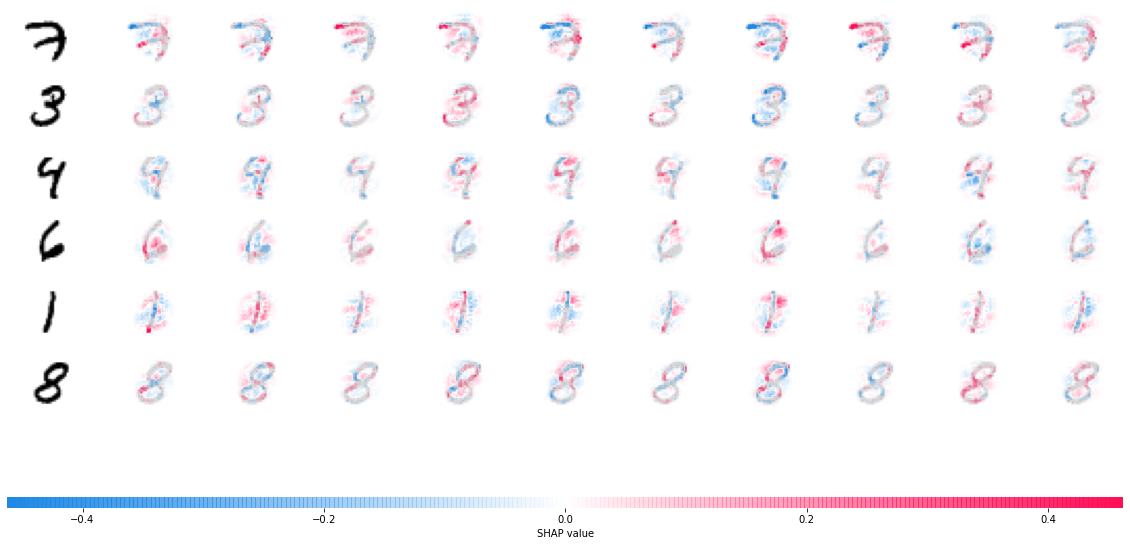

In [429]:
shap_numpy = [np.array(s.reshape(-1,28,28)) for s in shap_values]
test_numpy = test_images.numpy().reshape(-1,28,28)

shap.image_plot(shap_numpy, -test_numpy)